In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_gcn
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.mutagenicity import MutagenicityDataset

Keras utils: Register custom activation:  {'leaky_softplus': <function leaky_softplus at 0x0000027686BD8430>, 'shifted_softplus': <function shifted_softplus at 0x0000027686BD83A0>, 'softplus2': <function softplus2 at 0x0000027686BD8280>, 'leaky_relu': <function leaky_relu at 0x0000027686BD84C0>, 'swish': <function swish at 0x0000027686BD8550>}


## Load data

In [2]:
dataset = MutagenicityDataset()
labels, nodes, edge_indices, edges, atoms = dataset.get_graph()
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32) # Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)

INFO: Dataset directory located at C:\Users\Patrick\.kgcnn\datasets
INFO: Dataset directory found... done
INFO: Dataset found... done
INFO: Directory for extraction exists... done
INFO: Not extracting zip file ... stopped
INFO: Checking database...
INFO: Removing unconnected {'H': 66} from molecule 38
INFO: Removing unconnected {'H': 7} from molecule 133
INFO: Removing unconnected {'H': 9} from molecule 220
INFO: Removing unconnected {'H': 17} from molecule 246
INFO: Removing unconnected {'H': 170, 'C': 52, 'N': 17, 'O': 24, 'S': 4} from molecule 278
INFO: Removing unconnected {'H': 63} from molecule 296
INFO: Removing unconnected {'H': 26} from molecule 302
INFO: Removing unconnected {'H': 126, 'C': 42, 'N': 1, 'O': 4} from molecule 339
INFO: Removing unconnected {'H': 13} from molecule 743
INFO: Removing unconnected {'H': 10} from molecule 783
INFO: Removing unconnected {'H': 24} from molecule 1085
INFO: Removing unconnected {'H': 168, 'C': 50, 'N': 19, 'O': 20, 'S': 2} from molecule

## Make and train GCN

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


c:\users\patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
change_tensor_type (ChangeTenso [(None, 14), (None,) 0           node_input[0][0]                 
__________________________________________________________________________________________________
edge_input (InputLayer)         [(None, None, 1)]    0                                            
______________________________________________________________________________________________

c:\users\patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\users\patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape

109/109 - 4s - loss: 0.6559 - accuracy: 0.6103
Epoch 2/150
109/109 - 1s - loss: 0.6150 - accuracy: 0.6699
Epoch 3/150
109/109 - 1s - loss: 0.6011 - accuracy: 0.6769
Epoch 4/150
109/109 - 1s - loss: 0.5785 - accuracy: 0.7051
Epoch 5/150
109/109 - 1s - loss: 0.5561 - accuracy: 0.7195
Epoch 6/150
109/109 - 1s - loss: 0.5421 - accuracy: 0.7279
Epoch 7/150
109/109 - 1s - loss: 0.5378 - accuracy: 0.7267
Epoch 8/150
109/109 - 1s - loss: 0.5248 - accuracy: 0.7429
Epoch 9/150
109/109 - 1s - loss: 0.5145 - accuracy: 0.7434
Epoch 10/150
109/109 - 2s - loss: 0.5101 - accuracy: 0.7515 - val_loss: 0.5483 - val_accuracy: 0.7200
Epoch 11/150
109/109 - 1s - loss: 0.4993 - accuracy: 0.7604
Epoch 12/150
109/109 - 1s - loss: 0.5058 - accuracy: 0.7567
Epoch 13/150
109/109 - 1s - loss: 0.4979 - accuracy: 0.7613
Epoch 14/150
109/109 - 2s - loss: 0.4846 - accuracy: 0.7682
Epoch 15/150
109/109 - 1s - loss: 0.4844 - accuracy: 0.7682
Epoch 16/150
109/109 - 1s - loss: 0.4783 - accuracy: 0.7711
Epoch 17/150
109/10

109/109 - 1s - loss: 0.1730 - accuracy: 0.9288
Epoch 130/150
109/109 - 1s - loss: 0.1763 - accuracy: 0.9300 - val_loss: 0.8538 - val_accuracy: 0.7869
Epoch 131/150
109/109 - 1s - loss: 0.1750 - accuracy: 0.9245
Epoch 132/150
109/109 - 1s - loss: 0.1727 - accuracy: 0.9279
Epoch 133/150
109/109 - 1s - loss: 0.1723 - accuracy: 0.9308
Epoch 134/150
109/109 - 1s - loss: 0.1683 - accuracy: 0.9343
Epoch 135/150
109/109 - 1s - loss: 0.1690 - accuracy: 0.9300
Epoch 136/150
109/109 - 1s - loss: 0.1552 - accuracy: 0.9383
Epoch 137/150
109/109 - 1s - loss: 0.1452 - accuracy: 0.9429
Epoch 138/150
109/109 - 1s - loss: 0.1461 - accuracy: 0.9415
Epoch 139/150
109/109 - 1s - loss: 0.1546 - accuracy: 0.9389
Epoch 140/150
109/109 - 1s - loss: 0.1465 - accuracy: 0.9400 - val_loss: 0.8930 - val_accuracy: 0.7892
Epoch 141/150
109/109 - 1s - loss: 0.1553 - accuracy: 0.9386
Epoch 142/150
109/109 - 1s - loss: 0.1389 - accuracy: 0.9435
Epoch 143/150
109/109 - 1s - loss: 0.1896 - accuracy: 0.9288
Epoch 144/150
1

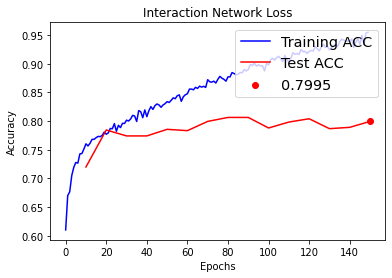

In [3]:
model = make_gcn(
    input_node_shape=[None,14],
    input_edge_shape=[None, 1],
    input_embedd={'input_node_vocab': 55, "input_node_embedd": 64},
    # Output
    output_embedd={"output_mode": 'graph', "output_type": 'padded'},
    output_mlp={"use_bias": [True, True, False], "units": [140, 70, 1], "activation": ['relu', 'relu', 'sigmoid']},
    # model specs
    depth=3,
    gcn_args={"units": 64, "use_bias": True, "activation": "relu", "has_unconnected": True, "is_sorted": False, "pooling_method": 'segment_mean'}
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_3.png')
plt.show()

## Implement the ExplainableGNN from GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, edge_input, edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        masked_node_feature_input = tf.ragged.map_flat_values(tf.math.multiply, masked_feature_input, node_mask)
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [5]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)

c:\users\patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


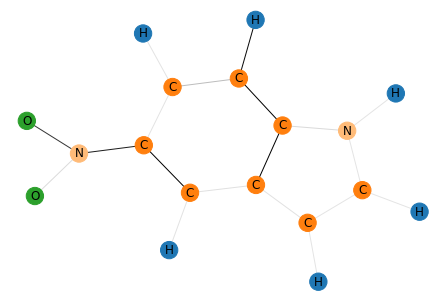

In [6]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

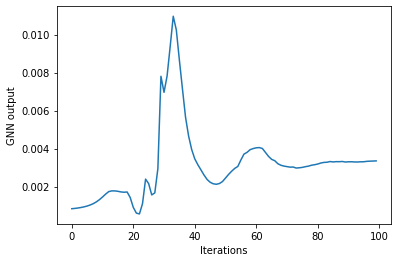

In [7]:
# Plot predicion
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

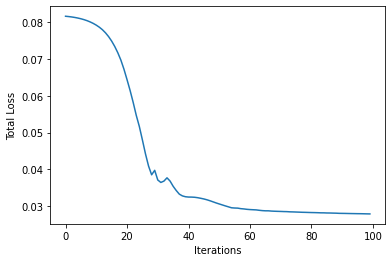

In [8]:
# PLot loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

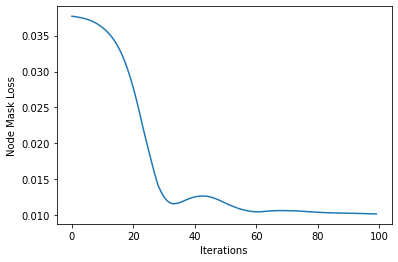

In [9]:
# Plot Edge Mask loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()

sample 200 mutagenic molecules:

In [10]:
pred = model.predict(xtest)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
print(sampled_mutagenic_molecules)

[316 225 839 202 153 178 367 190 405 520 139 567 537 857 659 543 313 733
 316 746 172 749 703 119 146 775 284 559   0 517 833 547 847 413 764 325
 415 588 579 518 582 723 773 466 859 334 387  56 866 296 183 308 419  68
  35  73 284 168 407  98 445  51 800 866 644 684 467 364  42 272 595 343
 388 316 579 709 309 749 567 667 352 653 187  68  52 346 335 118  44 243
 303  34 723 135 149 499 805 309 773 695 772 249 497   0 675 358  69 548
 768 149 287  68  69 790 466  49 832 462 334 548 647 739 824 650 639 659
 618 649 499  62  74 463 862 515 611 173 111 800  10 568 723 325  59  27
 832 605 650 324 719 196 347 176 334 198 730 616 443 146  62 105 288  75
 566 309 192 138 419 409 568 439 189 824 245 174 407 650 196 543 689 517
 837 226 848 800 367 321 177  49 603 243  26 117 372 520 715  36 584  16
  87 448]


Generate explanations for all those 50 molecules (this will take a while):

In [11]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain([tensor[mol_index:mol_index+1] for tensor in xtest])
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,WARNING:tensorflow:5 out of the last 715 calls to <function kgcnn_ops_change_edge_tensor_indexing_by_row_partition at 0x0000027686BAF040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1,WARNING:tensorflow:5 out of the last 15 calls to <function kgcnn_ops_change_edge_tensor_indexing_by_row_partition at 0x0000027686BAF040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creat

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [12]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

a dendogram of the explanation vectors:

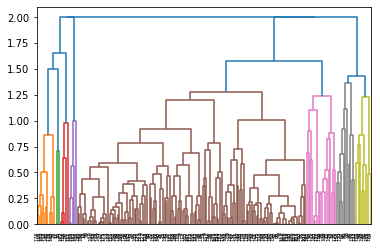

In [13]:
plt.figure()
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Print one representative graph explanation for each cluster:

(21, 105)


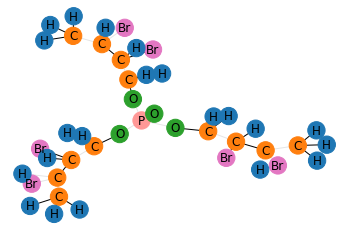

(137, 105)


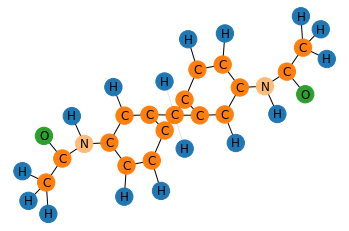

(18, 105)


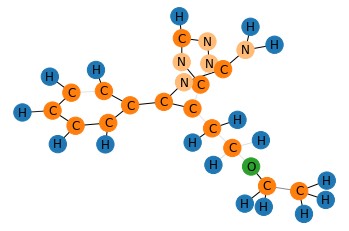

(11, 105)


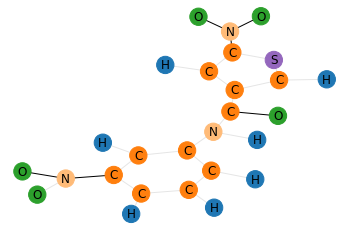

(5, 105)


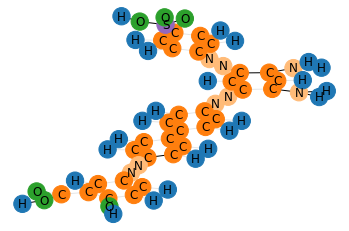

(5, 105)


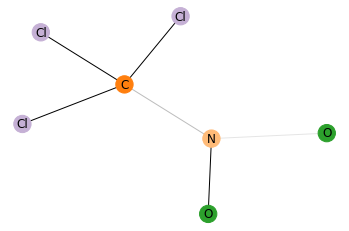

(3, 105)


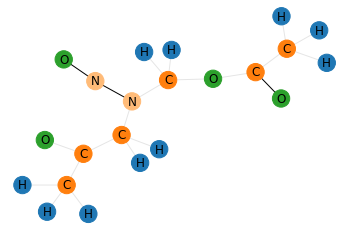

In [14]:
num_clusters = 7
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    plt.figure()
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()